<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/wordmark_black65ee464.png" width="700">

# Weekend Exercise (Ungraded)

During all the questions so far you've been asked to use simulators with no (or negligible) noise to do the computational tasks necessary. However, Quantum Computers today are far from ideal and noiseless. As coined by John Preskill we are in the [Noisy Intermediate Scale Quantum (NISQ)](https://arxiv.org/abs/1801.00862) era where our quantum computers are of the intermediate scale (50-100 qubits) and are very noisy, for example, a qubit initialized in the $|0\rangle$ state might not give $0$ on measurement in the computational basis all the time.

To understand the statement above lets do an experiment on a noiseless simulator and on an actual quantum computer and compare the results. 

### Simulator

In [2]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np

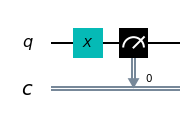

In [3]:
qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0,0)
qc.draw(output="mpl")

Once we build our circuit lets use the `qasm_simulator` from Aer to get the measurement counts

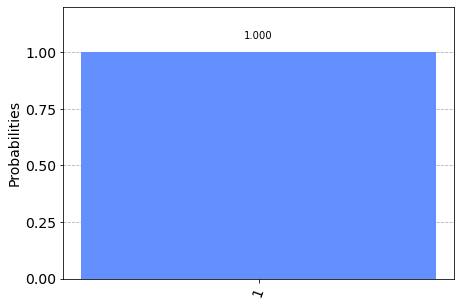

In [4]:
backend = Aer.get_backend("qasm_simulator")
job = execute(qc,backend=backend, shots =1000)
counts = job.result().get_counts()
plot_histogram(counts)

As you'd expect we received all 1000 counts to be corresponding to `1`. Now lets do the same experiment on a real device. 

### Real device

To run your experiments on a real device you'll first need to create(login into) an [IBM Quantum Experience](https://www.ibm.com/quantum-computing/technology/experience/) account and follow the instructions given [here](https://qiskit.org/documentation/install.html#install-access-ibm-q-devices-label) to be able to access IBM quantum services form Qiskit.

In [5]:
# only run this cell once, running it the second time might raise an error/warning as enable_account() already has your token stored
from qiskit import IBMQ

# to enabble your account you'll need to enter your token from IBM Quantum Experience in 'YOUR_IBM_TOKEN' in a string format 
IBMQ.save_account('ed4617679492e9c0f933116b0b62d0d110aa210faf481974a8720903b8c8c69febcb7158f1d044fedcac64bd11a94153e907aff42068a427f59e238464577816')

configrc.store_credentials:WARNING:2020-09-07 21:31:10,372: Credentials already present. Set overwrite=True to overwrite.


In [8]:
IBMQ.enable_account('ed4617679492e9c0f933116b0b62d0d110aa210faf481974a8720903b8c8c69febcb7158f1d044fedcac64bd11a94153e907aff42068a427f59e238464577816')

IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [9]:
# loading your account
IBMQ.load_account() 

# Getting a backend for running the circuit on. In this case 'ibm_armonk'. For more devices you have access to you 
# can look into your IBM Q Experience account's dashboard.
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend("ibmq_armonk")

ibmqfactory.load_account:WARNING:2020-09-06 21:28:11,995: Credentials are already in use. The existing account in the session will be replaced.


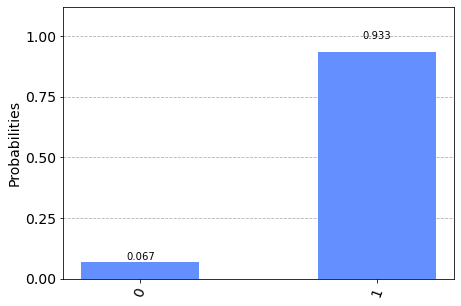

In [10]:
job = execute(qc,backend=backend,shots =1000)
counts = job.result().get_counts()
plot_histogram(counts)

From the above histogram we see that not all the counts resulted in a `1`. This is an example of the noise that gates induce. It's important to note that different gates induce different levels of noise into the system. For example, 2-qubit gates induce a lot more noise into the system than single qubit gates, hence while creating circuits to be run on real devices we should be wary of the number of 2-qubit gates being used and try to reduce them as much as possible. This idea will be the essence of the exercise today. [Chapter 5 of the Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/index-circuits.html) delves deeper into noise and some methods to tackle it if you're interested in learning more. 

While in today's exercise we won't be working with noisy simulators or real devices, lets take a step forward in understanding how to build circuits that give better results in the presence of noise. To do that lets dive into the exercise: 

## Exercise: Construct a 3 digit binary adder circuit with minimum cost.

You have learnt how to construct a binary half adder in [Chapter 1.2](https://qiskit.org/textbook/ch-states/atoms-computation.html) of the Qiskit Textbook. Using that knowledge we want you to create a 3 digit binary adder circuit which can do computations such as $101 + 110 = 1011$ where each input is a 3 digit binary number and the output is a four digit binary number. Your task is to find such a circuit with the least cost possible. The exercise is intentionally defined without many constraints to give you the freedom to test different data encoding schemes, basis gate sets, etc. 

Let us now define our cost function: 

**Cost of the circuit = Number of Single qubit gates + 10 $\times$ Number of CX gates** 

### The cost function

Any given quantum circuit can be decomposed into single-qubit and `CX` gates as they are a set of [universal quantum gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Universal_quantum_gates). With the current Noisy Intermediate-Scale Quantum (NISQ) devices noise introduced is higher when implementing a `CX` gate. Therefore, we  weigh `CX` gates 10 times more than a single-qubit gate while evaluating the cost of our circuit. To evaluate the cost of your circuit you can use the `cost_function()` method given below. 

The `cost_function()` takes as **input**: 

* `circuit`: (`QuantumCircuit`) -- The quantum circuit for which you'd like to find the cost.

And gives as **output**:


* `circuit_cost`: (`a`) -- Cost of the circuit


* `gates`: (`Dict`) -- Dictionary with the number of gates used in the circuit


* `unrolled_circuit`: (`QuantumCircuit`) -- The resultant circuit after change of basis

In [6]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


def cost_function(circuit):
    if not isinstance(circuit, (QuantumCircuit)):
        print("the inserted circuit must be a QuantumCircuit object, not {}".format(type(circuit)))
    else:
        basis_gate_set = ['u3', 'cx'] # basis that we are unrolling the circuit into

        # changing our basis using an Unroller
        pass_ = Unroller(basis_gate_set)
        pm = PassManager(pass_)
        unrolled_circuit = pm.run(circuit)

        # calculating the cost function using the equation given above
        gates = unrolled_circuit.count_ops()
        circuit_cost = gates['u3'] + 10*gates['cx']
        
    return circuit_cost, gates, unrolled_circuit

Internally, the `cost_function()` method uses an `Unroller` pass to convert our circuit to the {'u3', 'cx'} basis gate set and then applies the cost function equation as defined above. Here are a few resources to understand how the transpiler works: 

* Qiskit Terra Documentation - [Transpiler](https://qiskit.org/documentation/apidoc/transpiler.html)
* Advanced Circuit Tutorial - [Tranpiler Passes and Pass Manager](https://qiskit.org/documentation/tutorials/circuits_advanced/4_transpiler_passes_and_passmanager.html)


Let's understand how to use the `cost_function()` method by applying it on a half adder circuit as given in [Chapter 1.2](https://qiskit.org/textbook/ch-states/atoms-computation.html) of the Qiskit Textbook. 

In [7]:
# Constructing the Half Adder circuit

qc_ha = QuantumCircuit(4,2)
# encode inputs in qubits 0 and 1
qc_ha.x(0) # For a=0, remove the this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove the this line. For b=1, leave it.
qc_ha.barrier()
# use cnots to write the XOR of the inputs on qubit 2
qc_ha.cx(0,2)
qc_ha.cx(1,2)
# use ccx to write the AND of the inputs on qubit 3
qc_ha.ccx(0,1,3)
qc_ha.barrier()
# extract outputs
qc_ha.measure(2,0) # extract XOR value
qc_ha.measure(3,1) # extract AND value

qc_ha.draw()

┌───┐ ░                 ░       
q_0: ┤ X ├─░───■─────────■───░───────
     ├───┤ ░   │         │   ░       
q_1: ┤ X ├─░───┼────■────■───░───────
     └───┘ ░ ┌─┴─┐┌─┴─┐  │   ░ ┌─┐   
q_2: ──────░─┤ X ├┤ X ├──┼───░─┤M├───
           ░ └───┘└───┘┌─┴─┐ ░ └╥┘┌─┐
q_3: ──────░───────────┤ X ├─░──╫─┤M├
           ░           └───┘ ░  ║ └╥┘
c_0: ═══════════════════════════╩══╬═
                                   ║ 
c_1: ══════════════════════════════╩═

In [13]:
circuit_cost, gates, unrolled_circuit = cost_function(qc_ha)

print('Cost of the circuit : {}'.format(circuit_cost))
print('Gates counts after unrolling : {}'.format(gates))
print('Circuit after unrolling :')
unrolled_circuit.draw()

Cost of the circuit : 91
Gates counts after unrolling : OrderedDict([('u3', 11), ('cx', 8), ('barrier', 2), ('measure', 2)])
Circuit after unrolling :


┌─────────────┐ ░                                                  »
q_0: ┤ U3(pi,0,pi) ├─░─────────■─────────────────────────────────────■──»
     ├─────────────┤ ░         │                                     │  »
q_1: ┤ U3(pi,0,pi) ├─░─────────┼──────────■────■─────────────────────┼──»
     └─────────────┘ ░       ┌─┴─┐      ┌─┴─┐  │                     │  »
q_2: ────────────────░───────┤ X ├──────┤ X ├──┼─────────────────────┼──»
                     ░ ┌─────┴───┴─────┐└───┘┌─┴─┐┌───────────────┐┌─┴─┐»
q_3: ────────────────░─┤ U3(pi/2,0,pi) ├─────┤ X ├┤ U3(0,0,-pi/4) ├┤ X ├»
                     ░ └───────────────┘     └───┘└───────────────┘└───┘»
c_0: ═══════════════════════════════════════════════════════════════════»
                                                                        »
c_1: ═══════════════════════════════════════════════════════════════════»
                                                                        »
«                                                                »
«q_0: ────────────────────────────────────────■─────────■────────»
«                           ┌──────────────┐  │       ┌─┴─┐      »
«q_1: ──────────────────■───┤ U3(0,0,pi/4) ├──┼───────┤ X ├──────»
«                       │   └──────────────┘  │       └───┘      »
«q_2: ──────────────────┼─────────────────────┼──────────────────»
«     ┌──────────────┐┌─┴─┐┌───────────────┐┌─┴─┐┌──────────────┐»
«q_3: ┤ U3(0,0,pi/4) ├┤ X ├┤ U3(0,0,-pi/4) ├┤ X ├┤ U3(0,0,pi/4) ├»
«     └──────────────┘└───┘└───────────────┘└───┘└──────────────┘»
«c_0: ═══════════════════════════════════════════════════════════»
«                                                                »
«c_1: ═══════════════════════════════════════════════════════════»
«                                                                »
«      ┌──────────────┐      ░       
«q_0: ─┤ U3(0,0,pi/4) ├──■───░───────
«     ┌┴──────────────┤┌─┴─┐ ░       
«q_1: ┤ U3(0,0,-pi/4) ├┤ X ├─░───────
«     └───────────────┘└───┘ ░ ┌─┐   
«q_2: ───────────────────────░─┤M├───
«     ┌───────────────┐      ░ └╥┘┌─┐
«q_3: ┤ U3(pi/2,0,pi) ├──────░──╫─┤M├
«     └───────────────┘      ░  ║ └╥┘
«c_0: ══════════════════════════╩══╬═
«                                  ║ 
«c_1: ═════════════════════════════╩═
«